<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP1/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencias de los Datos:
# Aprendizaje automático

## Trabajo práctico 1

- Professor: M.Sc.Saul Calderon.

- Students: 
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  

- July 14th, 2019   

In [0]:
# Libraries required for the exercises
import torch
import matplotlib.pyplot as plt
import pylab
import cv2
from pandas import Timestamp
import pandas as pd
import numpy as np
from skimage import io
import urllib.request as ur

## 1. Implementación del algoritmo de Kittler

Original image


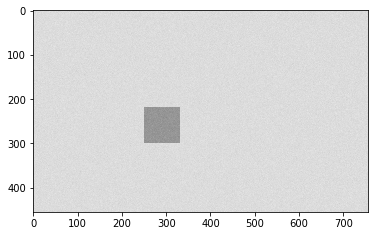



Image Histogram with 255 Bins


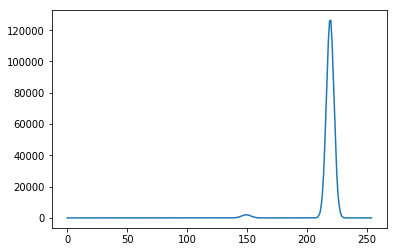



Image Normalized Histogram with 255 Bins


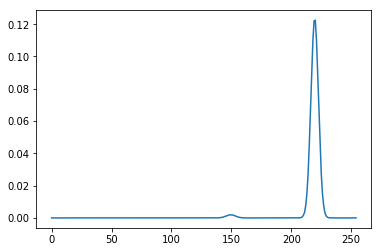

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


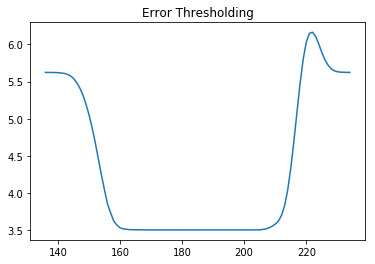

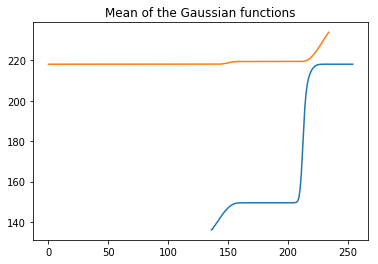

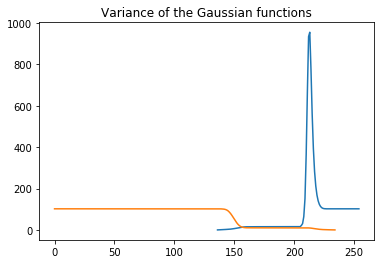


Obtained results:
Optimum threshold obtained:               168
Media in T of the Gaussian function 1:    tensor(149.4518)
Media in T of the Gaussian function 2:    tensor(219.4927)
Variance in T of the Gaussian function 1: tensor(15.3664)
Variance in T of the Gaussian function 2: tensor(10.0547)


Thresholded image


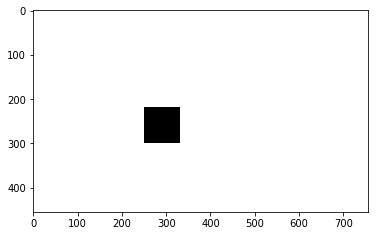

In [3]:
# Exercise 1.a - Kittler Algorithm

def exercise_1_a(img):

    def plotHistogram(df, title="Image Histogram with 255 Bins"):
        """
        Plot histogram.
        """
        print(title)
        plt.plot(df)
        plt.show()
        print("\n")
    
    def plotKittlerResults(J, mean1Vec, mean2Vec, sigma1Vec, sigma2Vec):
        """
        Plot Kittler Results.
        """
        plt.title("Error Thresholding")
        plt.plot(J.numpy())
        plt.show()
    
        plt.title("Mean of the Gaussian functions")
        plt.plot(mean1Vec.numpy())         
        plt.plot(mean2Vec.numpy())
        plt.show()
    
        plt.title("Variance of the Gaussian functions")
        plt.plot(sigma1Vec.numpy())
        plt.plot(sigma2Vec.numpy())
        plt.show()
    
    def showResults(threshold, mean1, mean2, sigma1, sigma2):
        """
        Show Kittler results.
        """
        print("\nObtained results:")
        print("Optimum threshold obtained:              ", threshold)
        print("Media in T of the Gaussian function 1:   ", mean1)
        print("Media in T of the Gaussian function 2:   ", mean2)
        print("Variance in T of the Gaussian function 1:", sigma1)
        print("Variance in T of the Gaussian function 2:", sigma2)

    def imageNormalizedHistogram(img):            
        """
        Computes the image normalized histogram.
        """
        
        # Calculate mean value from RGB channels and flatten to 1D array    
        vals = img.ravel()
        imageHist, g = np.histogram(img.ravel(),255,[0,255])    

        # Normalize the histogram
        imageHistNorm = imageHist/vals.shape[0]
    
        # Plot histogram with 255 bins
        plotHistogram(imageHist)
    
        # Plot normalize image histogram
        plotHistogram(imageHistNorm, title="Image Normalized Histogram with 255 Bins")

        return imageHist, imageHistNorm, g
    

    def KittlerV3(imageNormalizedHist, g):
        """
        Computes an optimal image threshold using the Kittler Algorithm Minimum Thresholding.
        Parameters:
           imagenNormalizedHist: the normalized histogram of the image.
                                 A torch vector expected to have integer values from 0 to 255.
           g: X axis of the histogram.
    
        Return: 
          T   : the optimal threshold.
          mean1: mean1 of T optimal.
          mean2: mean2 of T optimal.
          sigma1: sigma1 of T optimal.
          sigma2: sigma2 of T optimal.
        """
    
        #Initialized J and the result vectors
        J = torch.tensor(np.ones(255)*np.inf)
        mean1Vec  = torch.zeros(255)
        mean2Vec  = torch.zeros(255)
        sigma1Vec = torch.zeros(255)
        sigma2Vec = torch.zeros(255)
    
        # For each imageNormalizedHistogram value
        for T in range(255):
            #Split the normlized histogram at the threshold T.
            a1= 0
            b1= T+1
            a2= T
            b2= imageNormalizedHist.shape[0]-1
            imageHistogram1 = imageNormalizedHist[a1:b1]
            imageHistogram2 = imageNormalizedHist[a2:b2]
              
            #Sum the pixels of both clases               
            P1 = imageHistogram1.sum()
            P2 = imageHistogram2.sum()
        
            # Compute mean and sigma of each class.
            mean1 = (sum(imageNormalizedHist[z]*z for z in range(a1,b1))/P1)
            mean2 = (sum(imageNormalizedHist[z]*z for z in range(a2, b2))/P2)
            sigma1 = torch.sqrt((sum((imageNormalizedHist[x]* ((x-mean1)**2)) for x in range(a1,b1))/P1))
            sigma2 = torch.sqrt((sum((imageNormalizedHist[x]* ((x-mean2)**2)) for x in range(a2, b2))/P2))
        
            J[T] = torch.tensor (1 + 2 * (P1 * np.log(sigma1+0.1e-5) + P2 * np.log(sigma2+0.1e-5)) - 2 * (P1 * np.log(P1) + P2 * np.log(P2)))
            mean1Vec[T] = mean1
            mean2Vec[T] = mean2
            sigma1Vec[T] = sigma1**2
            sigma2Vec[T] = sigma2**2
    
        # Compute the min of J
        Jfinal = J.numpy()
        Jfinal[~np.isfinite(Jfinal)] = np.inf
        idx = np.argmin(Jfinal)
        threshold = int(g[idx])   
    
        # Plot the results
        plotKittlerResults(J, mean1Vec, mean2Vec, sigma1Vec, sigma2Vec)
  
        return threshold, mean1Vec[idx], mean2Vec[idx], sigma1Vec[idx], sigma2Vec[idx]
    
    # Plot Normalized Histogram
    imageHist, imageHistNorm, g = imageNormalizedHistogram(img)
    
    # Applied Kittler Algorithm and Plot J(T) function
    threshold, mean1, mean2, sigma1, sigma2 = KittlerV3 (torch.tensor(imageHistNorm), g)
    
    # Show Kittler results
    showResults(threshold, mean1, mean2, sigma1, sigma2)
    return threshold

def plotOriginalImage(imgPath):
  img = io.imread(imgPath)
  
  # Plot Original Image
  print("Original image")
  plt.imshow(img, cmap='gray')
  plt.show()
  print("\n")
  return img

def plotThresholdedImage(imgPath, threshold):
  # Applied threshold to image
  img = io.imread(imgPath)
  out = io.imread(imgPath)
  out[:,:] = 0
  out[img >= threshold] = 255
  
  # Plot Thresholded Image
  print("\n\nThresholded image")
  plt.imshow(out, cmap='gray')
  plt.show()
  
def exercise1(imgPath='https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP1/input/cuadro1_005.bmp'):
  # Plot Original Image
  image = plotOriginalImage(imgPath)
  
  # Test exercise 1.a
  threshold = exercise_1_a(image)
  
  # Test exercise 1.b
  plotThresholdedImage(imgPath, threshold)

# Test exercise 1
exercise1()

#Son coherentes tales valores obtenidos por el algoritmo con el histograma de la imágen?
Sí, los resultados son coherentes porque el umbral óptimo obtenido divide la intensidad de grises de la imágen perfectamente de acuerdo al historgrama.


#Lograría el umbral óptimo τ obtenido umbralizar satisfactoriamente la imagen de prueba?
Sí, como se muestra en el resultado la imagen de prueba se logra umbralizar perfectamente.




## 2. Calcule el umbral óptimo con el algoritmo de Kittler, y umbralice la imagen de trackedCell15.tif

Original image


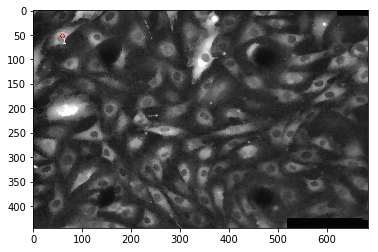



Image Histogram with 255 Bins


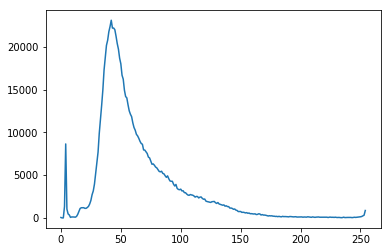



Image Normalized Histogram with 255 Bins


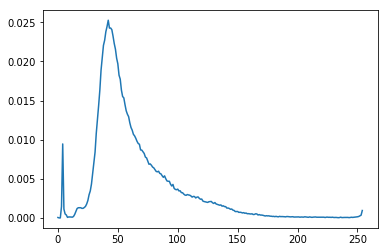

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log


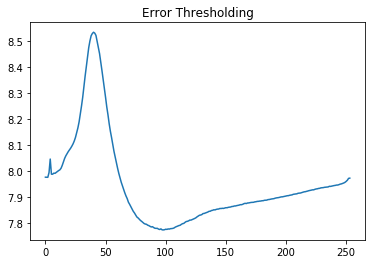

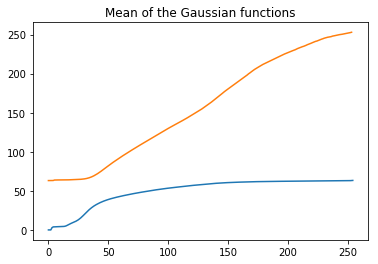

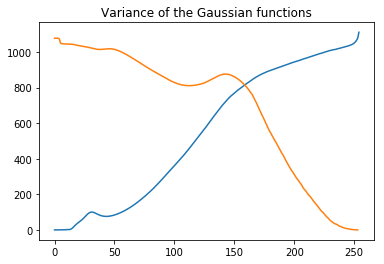


Obtained results:
Optimum threshold obtained:               98
Media in T of the Gaussian function 1:    tensor(53.0399)
Media in T of the Gaussian function 2:    tensor(128.2649)
Variance in T of the Gaussian function 1: tensor(345.5976)
Variance in T of the Gaussian function 2: tensor(834.3124)


Thresholded image


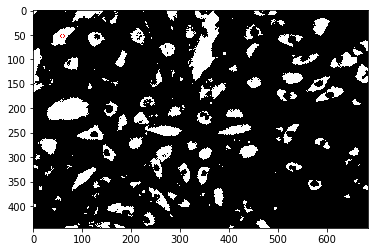

In [0]:
#Exercise 2
def exercise2(imgPath='https://www.dropbox.com/sh/wik46x4bhv5hhgv/AAB-XniFCk1jTttL5MQ_MulTa/TrabajosPracticos/TP1/input/trackedCell15.tif?dl=1'):
  # Plot Original Image
  image = plotOriginalImage(imgPath)
  
  # Apply Kittler Algorithm
  threshold = exercise_1_a(image)
  
  # Plot Threshold Image
  plotThresholdedImage(imgPath, threshold)

# Test exercise 2
exercise2()
